In [3]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

In [4]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import random

from firedrake.petsc import PETSc

/tmp/ipython-input-6-1894416273.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left')


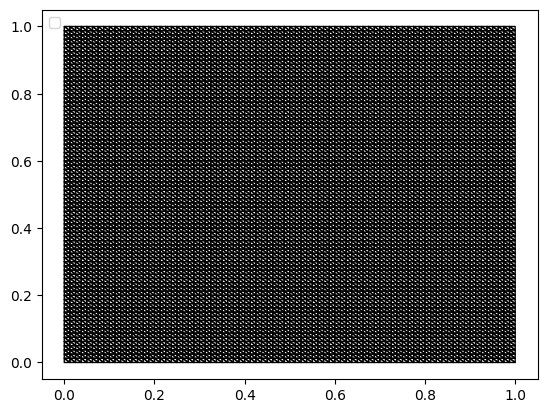

In [6]:
mesh = PeriodicUnitSquareMesh(80,80,direction="both")
fig, ax = plt.subplots()
triplot(mesh, axes=ax)
ax.legend(loc='upper left')

In [7]:
U=FunctionSpace(mesh,'P',1)
V=FunctionSpace(mesh,'P',1)
W=MixedFunctionSpace([U,V])

In [8]:
#Parameters
dt = 2.0e-02

Al=Constant(1.0)
b=Constant(-1.0)
c=Constant(2)
d=Constant(-1.5)
mu=Constant(0.0001)
nu=Constant(0.0006)


G = Constant(0.9)
A = Constant(6.0)
B = Constant(4.0)
D = Constant(20.0)



In [9]:
def Turing_Homogeneous(u,v,v1,v2,dt,u_old,v_old):
  a=1/dt*inner(u,v1)*dx\
    +mu*inner(grad(u),grad(v1))*dx\
    -Al*dot(u,v1)*dx\
    -b*dot(v,v1)*dx\
    +1/dt*inner(v,v2)*dx\
    +nu*inner(grad(v),grad(v2))*dx\
    -c*dot(u,v2)*dx\
    -d*dot(v,v2)*dx
  L=1/dt*inner(u_old,v1)*dx\
    +1/dt*inner(v_old,v2)*dx
  return a,L

In [10]:
u,v=TrialFunctions(W)
v1,v2=TestFunctions(W)

u_=Function(W)
uh,vh=u_.subfunctions

u_n =Function(W) #old solution, time: n-1
u_old, v_old =u_n.subfunctions


#IC (random initializzation)
#component 1
n0 = uh.dat.data.shape[0]
uh.dat.data[:] = 0.1*np.random.rand(n0) - 0.1*np.random.rand(n0)
# Component 2
n1 = vh.dat.data.shape[0]
vh.dat.data[:] = 0.1*np.random.rand(n1) - 0.1*np.random.rand(n1)

u_old.assign(uh)
v_old.assign(vh)

Coefficient(WithGeometry(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7cb8a8254190>, FiniteElement('Lagrange', triangle, 1), name=None, index=1, component=None), Mesh(VectorElement(FiniteElement('Discontinuous Lagrange', triangle, 1, variant='equispaced'), dim=2, variant='equispaced'), 10)), 43)

In [11]:
param = {'ksp_type': 'gmres',
         'pc_type': 'ilu',
         'ksp_rtol ': 1.e-8,
         'ksp_max_it': 2000 ,
         "ksp_monitor ": None  }

In [12]:
a,L=Turing_Homogeneous(u,v,v1,v2,dt,u_old,v_old)
problem=LinearVariationalProblem(a,L,u_)
solver=LinearVariationalSolver(problem,solver_parameters=param)
solver.solve()

In [13]:
basename = 'Turing_Pattern'
outfileU = File("/content/drive/MyDrive/4Test/pop1_H.pvd")
outfileV = File("/content/drive/MyDrive/4Test/pop2_H.pvd")


u_old.rename("pop1")   # this names will be used in Paraview
v_old.rename("pop2")
outfileU.write(u_old)
outfileV.write(v_old)


/usr/local/lib/python3.11/dist-packages/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


In [14]:
t = 0.0
T=900*dt
time_vec = np.arange(0, T, dt)  # endtime+0.1*dt to include also endtime: range/arange exclude the upper bound of the range


for ii in range(1, len(time_vec)):     # start from 1 to skip time=0
    t = time_vec[ii]
    print('Time = ', t)

    a,L=Turing_Homogeneous(u,v,v1,v2,dt,u_old,v_old)
    problem=LinearVariationalProblem(a,L,u_)
    solver=LinearVariationalSolver(problem,solver_parameters=param)
    solver.solve()
    uh,vh=u_.subfunctions

    print('||u||L^2',errornorm(uh,u_old,'L2')/norm(u_old),'||v||L^2',errornorm(vh,v_old,'L2')/norm(v_old))

    uh.rename("pop1")
    vh.rename("pop2")


    # Post-processing
    outfileU.write(u_old, time=t)
    outfileV.write(v_old, time=t)

    u_old.assign(uh)
    v_old.assign(vh)

Time =  0.02
||u||L^2 0.10070957155283355 ||v||L^2 0.378918017358797
Time =  0.04
||u||L^2 0.09046754856166928 ||v||L^2 0.28489015343926566
Time =  0.06
||u||L^2 0.08116144425560762 ||v||L^2 0.21780822749233705
Time =  0.08
||u||L^2 0.07280064261260366 ||v||L^2 0.17515463736812678
Time =  0.1
||u||L^2 0.06537566243661551 ||v||L^2 0.1479813884066976
Time =  0.12
||u||L^2 0.0588411927097931 ||v||L^2 0.129746064418911
Time =  0.14
||u||L^2 0.05312540279908849 ||v||L^2 0.11671118851793913
Time =  0.16
||u||L^2 0.048142694727427306 ||v||L^2 0.10681960853512334
Time =  0.18
||u||L^2 0.04380401994609564 ||v||L^2 0.09890574403056668
Time =  0.2
||u||L^2 0.04002373811879818 ||v||L^2 0.09228015489774796
Time =  0.22
||u||L^2 0.03672348350815484 ||v||L^2 0.08652043244410497
Time =  0.24
||u||L^2 0.033833861787778696 ||v||L^2 0.08136289339120381
Time =  0.26
||u||L^2 0.03129474901389292 ||v||L^2 0.07664293681639271
Time =  0.28
||u||L^2 0.029054788115677486 ||v||L^2 0.07225959113100386
Time =  0.3

Text(0.5, 1.0, 'population')

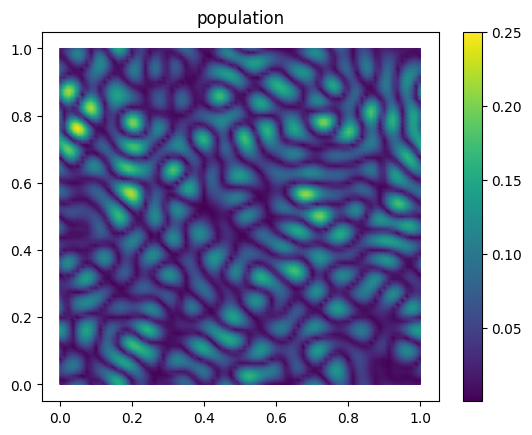

In [15]:
fig, ax = plt.subplots()
col = tripcolor(u_, axes=ax)
plt.colorbar(col)
plt.title('population')